In [1]:
%load_ext autoreload

# Probabilistic Principal Component Analysis

In [2]:
import os
import torch
import numpy as np

from pdmtut.core import GenerativeModel
from sklearn.decomposition import PCA
from joblib import dump, load

In [3]:
store_results = True

## Introduction

## Implementation

In [4]:
class PPCAModel(GenerativeModel):
    def __init__(self, n_components):
        self.n=n_components
        self.pca = PCA(n_components=self.n, svd_solver='full', whiten=True)

    @property
    def n_components(self):
        return self.pca.n_components_

    def fit_model(self, X):
        self.pca.fit(X)

    def encode(self, X):
        # based on https://tvml.github.io/ml1718/slides/probabilistic_pca.pdf
        _X = (X - self.pca.mean_).numpy()
        W = self.pca.components_ * np.sqrt(
            self.pca.explained_variance_[:, np.newaxis])
        sigma2 = self.pca.noise_variance_

        M = W @ W.T + sigma2*np.eye(self.pca.n_components_)
        z_exp = _X @ (W.T @ np.linalg.inv(M))

        return torch.from_numpy(z_exp)

    def decode(self, X):
        return torch.from_numpy(self.pca.inverse_transform(X))

    def save(self, path):
        if path is not None:
            dump(self, os.path.join(path, 'model.joblib')) 
    
    def load(path):
        if path is not None:
            return load(os.path.join(path, 'model.joblib'))
    
    def save_exists(path):
        return os.path.isfile(os.path.join(path, 'model.joblib'))
        

    def log_likelihood(self, X):
        return torch.from_numpy(self.pca.score_samples(X))

    def sample_posterior(self, n_samples, include_noise=False):
        z_samples = np.random.normal(0, 1, [n_samples, self.pca.n_components_])

        if include_noise:
            # x ∼ N(Wᵀz, σI)
            # TODO: do this more efficiently
            samples = np.concatenate(
                [np.random.multivariate_normal(
                    self.pca.inverse_transform(z),
                    self.pca.noise_variance_ * np.eye(self.pca.n_features_) , 1)
                for z in z_samples]
            )
        else:
            # x = Wᵀz
            samples = self.pca.inverse_transform(z_samples)


        return torch.from_numpy(samples)

    def __str__(self):
        return 'ppca_{}_components'.format(self.n)

## Experiment 1a: swiss roll (2-components)

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

if store_results:
    result_save_path = '../experiments/swiss_roll/results/ppca_2_components'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if PPCAModel.save_exists(result_save_path):
    model = PPCAModel.load(result_save_path)
else:
    model = PPCAModel(n_components=2)
    model.fit_model(dataset.X)
    model.save(result_save_path)

### Input Representation

In [8]:
from pdmtut.vis import plot_representation

In [9]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

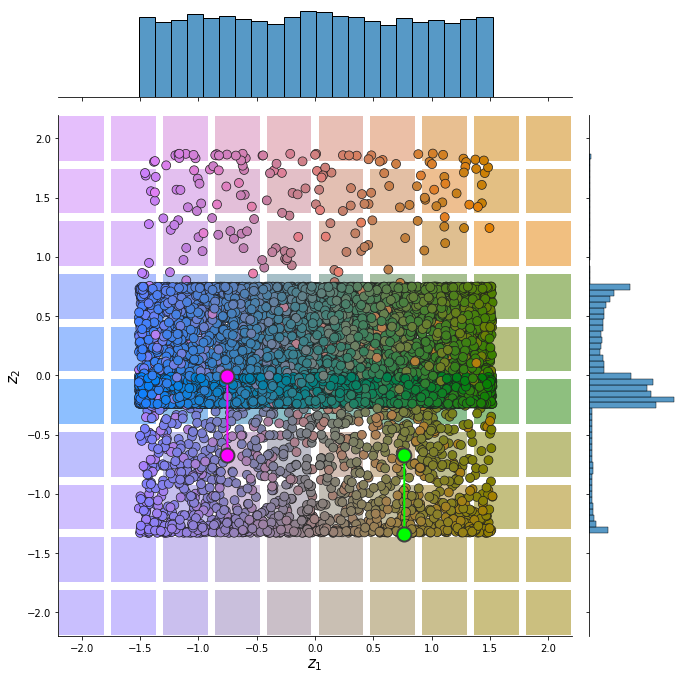

In [10]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [11]:
from pdmtut.vis import plot_reconstruction

In [12]:
z = model.encode(dataset.X)
x = model.decode(z)

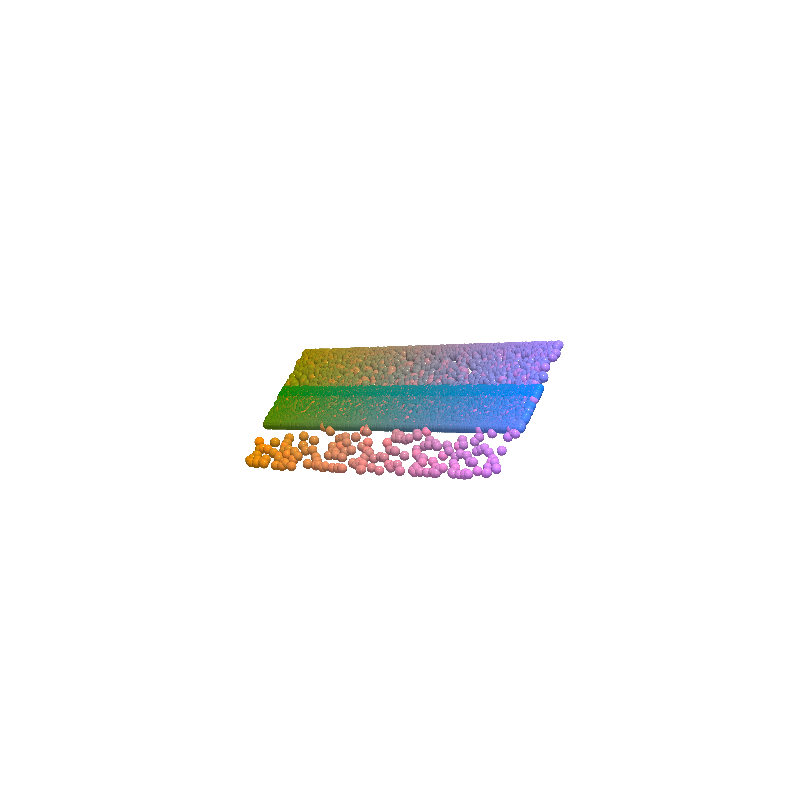

In [13]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [14]:
from pdmtut.vis import plot_density

In [15]:
log_likelihood = model.log_likelihood(dataset.X)

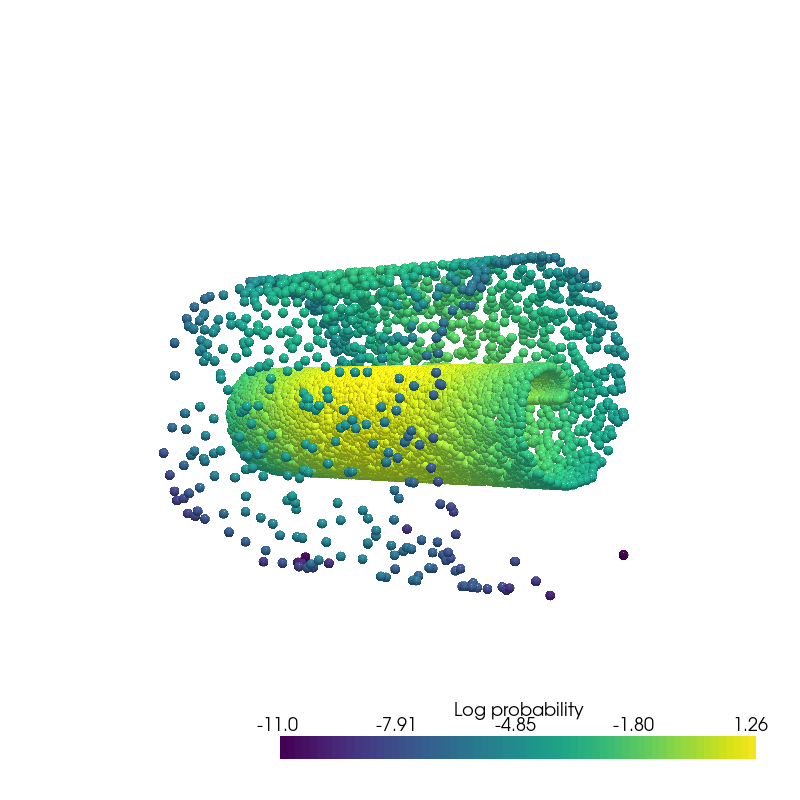

In [16]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [17]:
from pdmtut.vis import plot_generated_samples

In [18]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

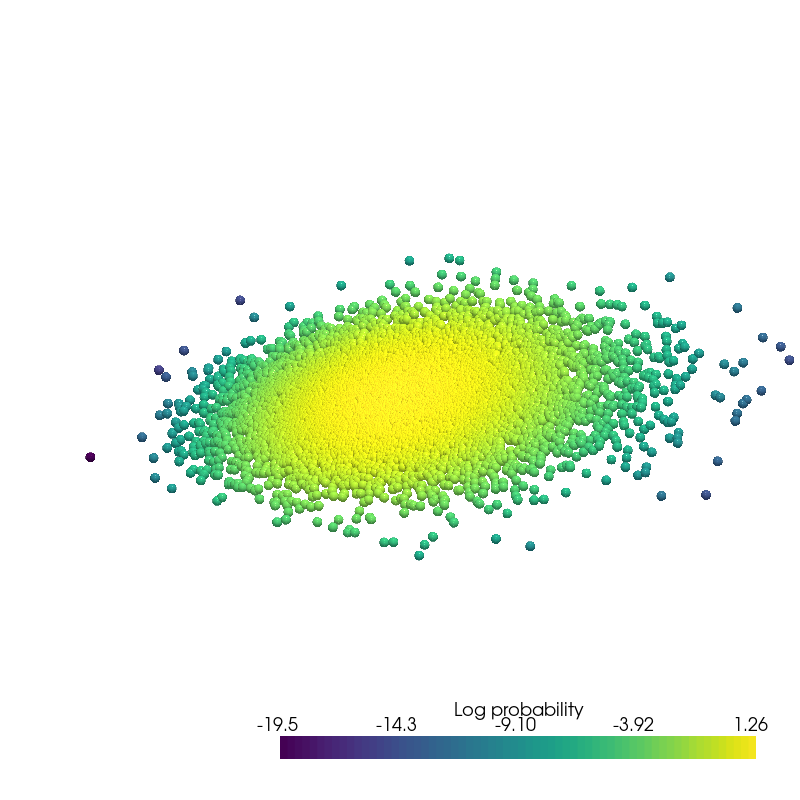

In [19]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [20]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [21]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

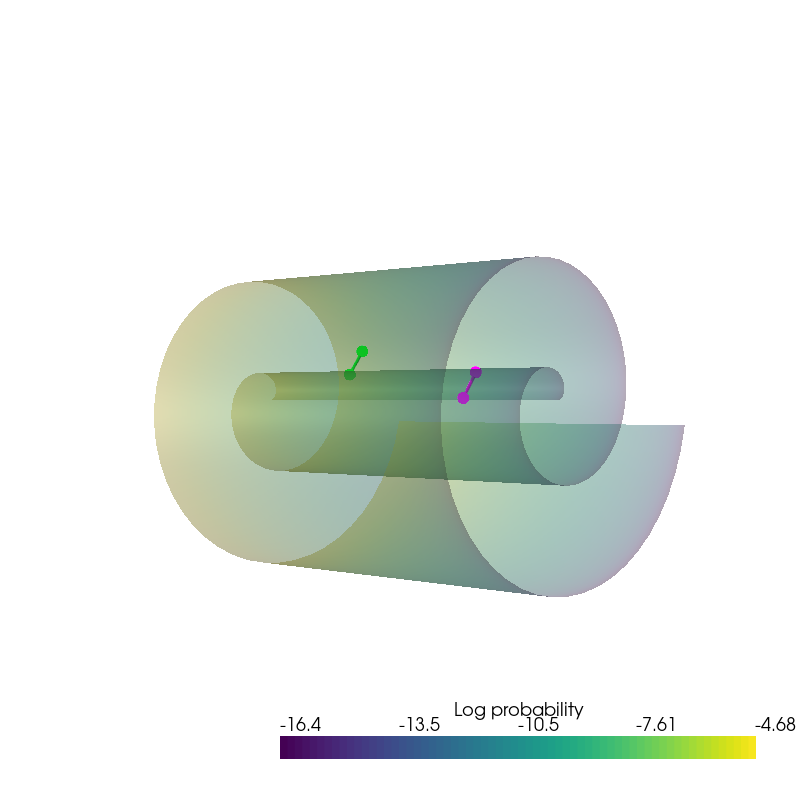

In [22]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)

## Experiment 1b: swiss roll (3-components)

In [23]:
pv.set_plot_theme("document")

if store_results:
    result_save_path = '../experiments/swiss_roll/results/ppca_3_components'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [25]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if PPCAModel.save_exists(result_save_path):
    model = PPCAModel.load(result_save_path)
else:
    model = PPCAModel(n_components=2)
    model.fit_model(dataset.X)
    model.save(result_save_path)

In [26]:
from pdmtut.vis import plot_representation

In [27]:
z = model.encode(dataset.X)
z_extremes = model.encode(dataset.y_extremes)

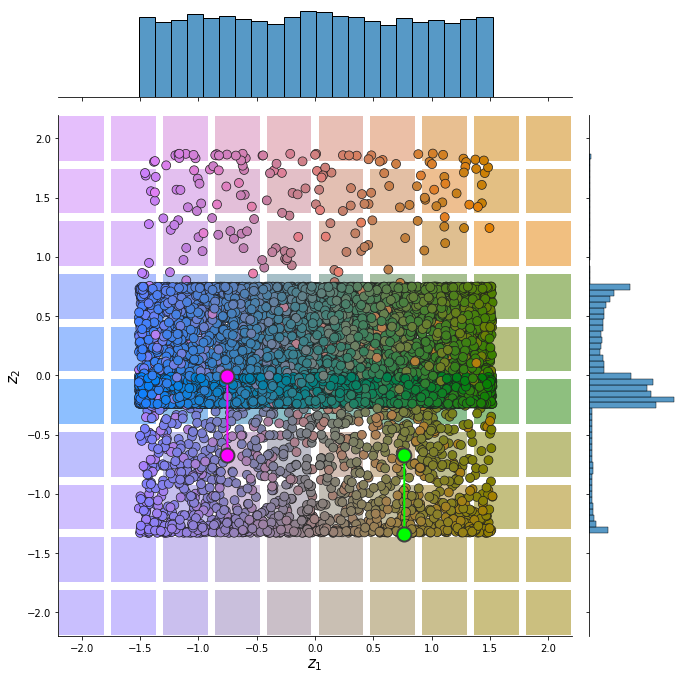

In [28]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [29]:
from pdmtut.vis import plot_reconstruction

In [30]:
z = model.encode(dataset.X)
x = model.decode(z)

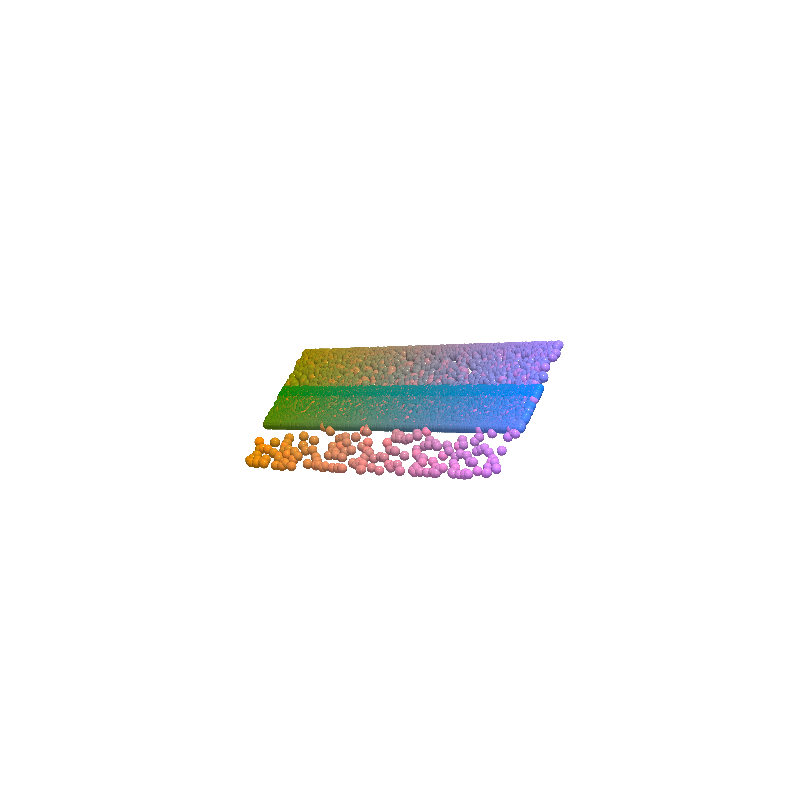

In [31]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [32]:
from pdmtut.vis import plot_density

In [33]:
log_likelihood = model.log_likelihood(dataset.X)

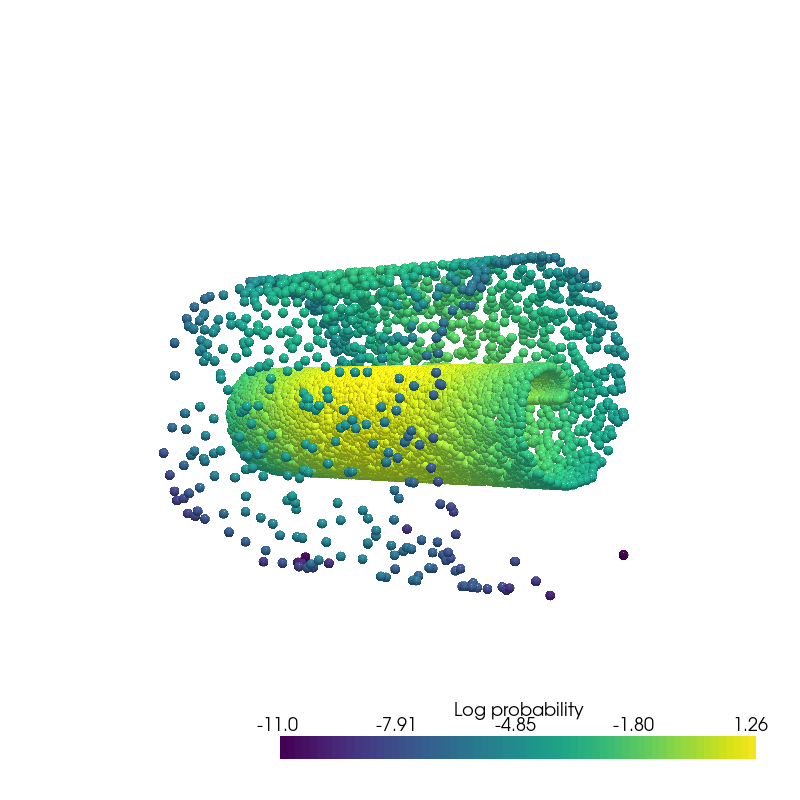

In [34]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [35]:
from pdmtut.vis import plot_generated_samples

In [36]:
generated_samples = model.sample_posterior(100**2)
generated_samples_log_likelihood = model.log_likelihood(generated_samples)

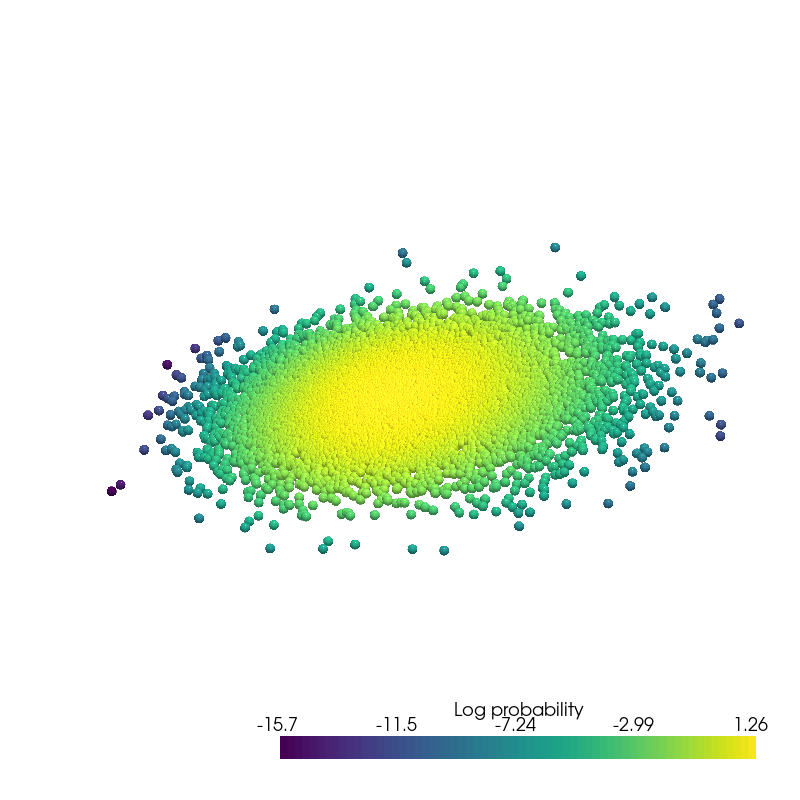

In [37]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [38]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [39]:
z_extremes = model.encode(dataset.y_extremes)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))))
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))))

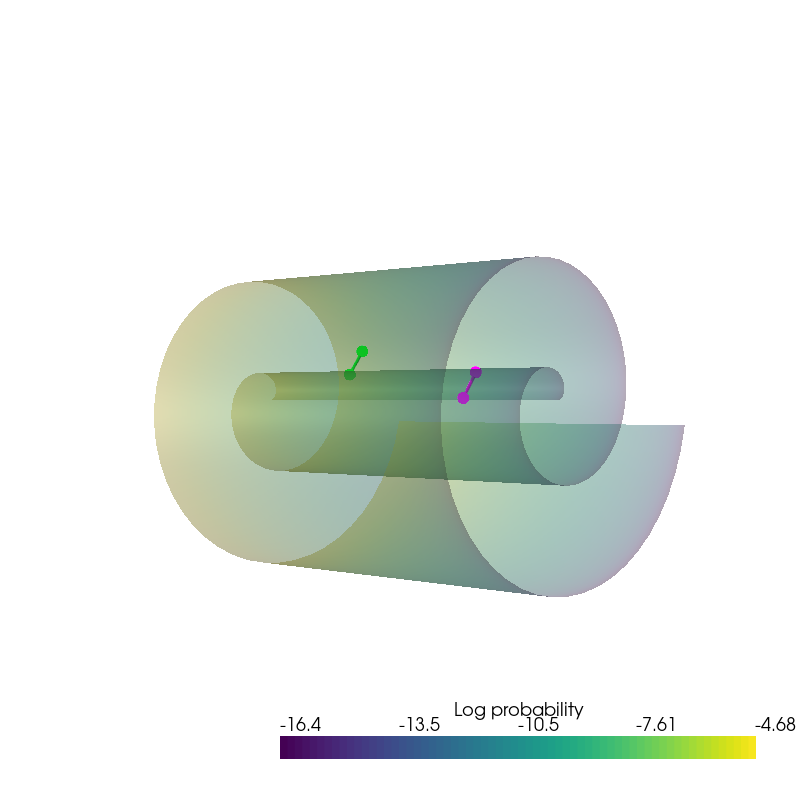

In [40]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)